In [21]:
import rospy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from nav_msgs.msg import Odometry
from sensor_msgs.msg import LaserScan
from rt1_assignment2_1.msg import Odom_simplified
from assignment_2_2024.msg import PlanningAction, PlanningGoal
import actionlib
from actionlib_msgs.msg import GoalStatus
import ipywidgets as widgets
from IPython.display import display, clear_output
from geometry_msgs.msg import Pose

# Initialize the ROS node (disable_signals for Jupyter)
rospy.init_node('robot_target_node', disable_signals=True)

ROSException: rospy.init_node() has already been called with different arguments: ('robot_target', ['/usr/local/lib/python3.8/dist-packages/ipykernel_launcher.py', '-f', '/root/.local/share/jupyter/runtime/kernel-14cf336d-7c52-438a-9637-0a62fe9879b4.json'], True, None, False, False)

In [27]:
class RobotTarget:
    def __init__(self):
        # State
        self.position_history = []
        self.reached_goals = 0
        self.failed_goals = 0
        self.latest_position = (0, 0)
        self.closest_obstacle = float('inf')

        # Widgets FIRST
        self.x_widget = widgets.FloatText(description='X:', disabled=True)
        self.y_widget = widgets.FloatText(description='Y:', disabled=True)
        self.dist_widget = widgets.FloatText(description='Closest Obs:', disabled=True)
        self.goal_x = widgets.FloatText(description='Goal X:')
        self.goal_y = widgets.FloatText(description='Goal Y:')
        self.send_button = widgets.Button(description='Send Goal', button_style='success')
        self.cancel_button = widgets.Button(description='Cancel Goal', button_style='danger')
        self.send_button.on_click(self.send_goal)
        self.cancel_button.on_click(self.cancel_goal)

        # Display UI
        display(widgets.HBox([self.x_widget, self.y_widget, self.dist_widget]))
        display(widgets.HBox([self.goal_x, self.goal_y, self.send_button, self.cancel_button]))

        # ROS connections AFTER widgets
        self.ac = actionlib.SimpleActionClient('reaching_goal', PlanningAction)
        self.ac.wait_for_server()
        self.odom_sub = rospy.Subscriber('/odom', Odometry, self.odom_callback)
        self.scan_sub = rospy.Subscriber('/scan', LaserScan, self.scan_callback)
        self.odom_pub = rospy.Publisher('/odom_simplified', Odom_simplified, queue_size=10)

    def odom_callback(self, msg):
        x = msg.pose.pose.position.x
        y = msg.pose.pose.position.y
        self.latest_position = (x, y)
        self.position_history.append((x, y))
        self.x_widget.value = round(x, 2)
        self.y_widget.value = round(y, 2)

        simplified = Odom_simplified()
        simplified.x = x
        simplified.y = y
        simplified.vel_x = msg.twist.twist.linear.x
        simplified.vel_z = msg.twist.twist.angular.z
        self.odom_pub.publish(simplified)

    def scan_callback(self, msg):
        ranges = np.array(msg.ranges)
        valid = ranges[np.isfinite(ranges)]
        if valid.size > 0:
            self.closest_obstacle = np.min(valid)
            self.dist_widget.value = round(self.closest_obstacle, 2)

    def send_goal(self, b=None):
        goal = PlanningGoal()
        goal.target_pose.header.stamp = rospy.Time.now()
        goal.target_pose.header.frame_id = "odom"
        goal.target_pose.pose.position.x = self.goal_x.value
        goal.target_pose.pose.position.y = self.goal_y.value
        self.ac.send_goal(goal, done_cb=self.goal_done_cb)

    def cancel_goal(self, b=None):
        self.ac.cancel_goal()

    def goal_done_cb(self, state, result=None):
        if state == GoalStatus.SUCCEEDED:
            self.reached_goals += 1
            rospy.loginfo("Goal reached.")
        else:
            self.failed_goals += 1
            rospy.logwarn("Goal not reached.")

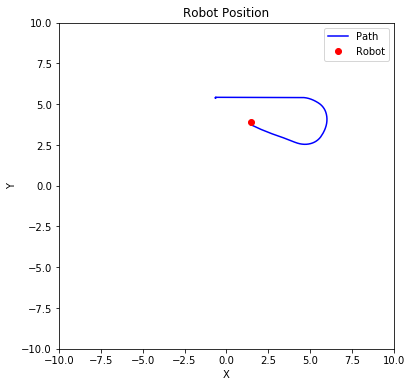

In [34]:
fig, ax = plt.subplots(figsize=(6, 6))
line, = ax.plot([], [], 'b-', label='Path')
point, = ax.plot([], [], 'ro', label='Robot')
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
ax.set_title("Robot Position")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.legend()

def update(frame):
    if robot.position_history:
        xs, ys = zip(*robot.position_history)
        line.set_data(xs, ys)
        point.set_data(xs[-1], ys[-1])
    return line, point

ani = FuncAnimation(fig, update, interval=500)
plt.show()


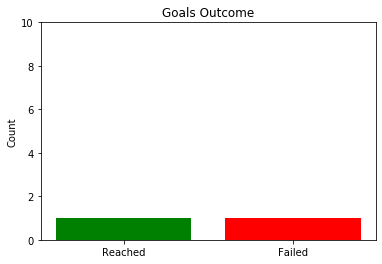

In [33]:
fig2, ax2 = plt.subplots()
bars = ax2.bar(['Reached', 'Failed'], [0, 0], color=['green', 'red'])
ax2.set_ylim(0, 10)
ax2.set_title("Goals Outcome")
ax2.set_ylabel("Count")

def update_bars(frame):
    bars[0].set_height(robot.reached_goals)
    bars[1].set_height(robot.failed_goals)
    return bars

ani2 = FuncAnimation(fig2, update_bars, interval=1000)
plt.show()


In [28]:
robot = RobotTarget()

[WARN] [1746050775.580547, 3849.530000]: Goal not reached.
